# 応用的なOptimizer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import init
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import nn, optim
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2
import utils

## EMA

- 指数移動平均(EMA)の結果を描画する
- y=sin(x)に対してEMAを計算し描画する
- EMAt = αEMAt-1 + (1-α)Xt

In [23]:
x = np.linspace(0, 2*np.pi, 10)
y = np.sin(x)

ema = 0
alpha = 0.9  # alphaを0〜1で大きくしていくとEMAが滑らかになっていく
results = []
# EMA
for y_i in y:
    ema = alpha * ema + (1-alpha) * y_i
    results.append(ema)

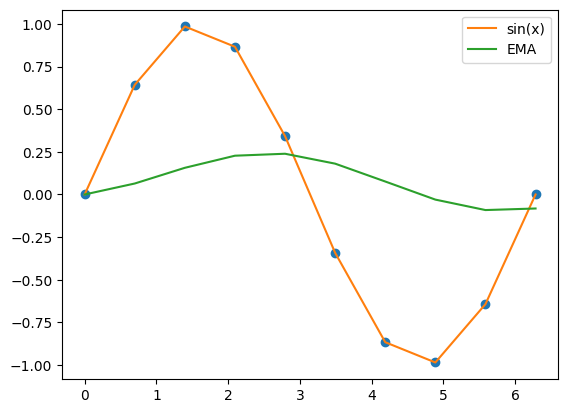

In [24]:
plt.plot(x, y, 'o')
plt.plot(x, y, '-', label='sin(x)')
plt.plot(x, results, label='EMA')
plt.legend()

## Momentum

### スクラッチ実装

- 以前作成したOptimizerクラスを改良する
    - モデルのパラメータ、学習率、Momentumの係数を引数に取る
    - Stepメソッド
        - パラメータを更新する
        - 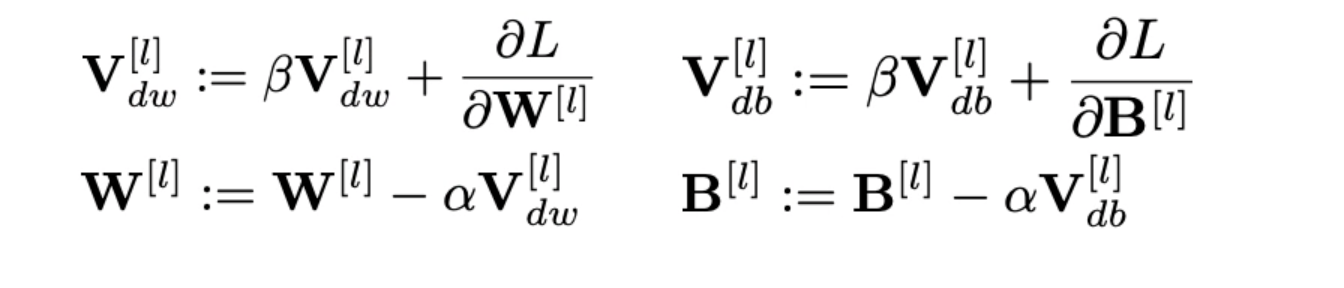
    - zero_gradメソッド
        - 勾配をリセットする

In [26]:
# 以下のクラスは第一部のOptimizerのセクションから
class Optimizer():

    def __init__(self, parameters, lr=0.03):
        self.parameters = list(parameters)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.parameters:
                param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [55]:
class MomentumOptimizer():

    def __init__(self, parameters, lr=0.03, momentum=0.9):
        self.parameters = list(parameters)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(param) for param in self.parameters] 

    def step(self):
        with torch.no_grad():
            for param, v in zip(self.parameters, self.v):
                v[:] = self.momentum * v + param.grad
                param -= self.lr * v
    
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [48]:
v = [torch.tensor([1.,2.,3.]), torch.tensor([4.,5.,6.])]
for v_ in v:
    v_ = torch.tensor([0., 0., 0.])  # もとのtensorを置き換えてもこの書き方だと更新されない
    # v_[:] = torch.tensor([0., 0., 0.])
v

[tensor([1., 2., 3.]), tensor([4., 5., 6.])]

In [56]:
v = [torch.tensor([1.,2.,3.]), torch.tensor([4.,5.,6.])]
for v_ in v:
    # v_ = torch.tensor([0., 0., 0.])  # もとのtensorを置き換えてもこの書き方だと更新されない
    v_[:] = torch.tensor([0., 0., 0.])  # この書き方だとtensorが更新される
v

[tensor([0., 0., 0.]), tensor([0., 0., 0.])]

In [57]:
conv_model = utils.get_conv_model()

In [6]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,) )
])
train_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=4)

# Optimizer
opt = MomentumOptimizer(conv_model.parameters(), lr=0.03, momentum=0.9)  # スクラッチ実装したクラス

NameError: name 'MomentumOptimizer' is not defined

In [59]:
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 1.2549782789359658, validation error: 0.7821166574954986, validation accuracy: 0.7271584033966064


epoch: 1: train error: 0.6382732189307778, validation error: 0.5883362054824829, validation accuracy: 0.7839943408966065


epoch: 2: train error: 0.5229613760770377, validation error: 0.5171427875757217, validation accuracy: 0.8076988995075226


### PytorchのOptimizer

- torch.optim.SGDのmomentum引数に減衰係数(β)を指定する

In [62]:
# Optimizer
opt = optim.SGD(conv_model.parameters(), lr=0.03, momentum=0.9)  # Pytorchのクラス、momentum引数を使用

# 学習
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.4726280307365676, validation error: 0.4843453288078308, validation accuracy: 0.8210618615150451


epoch: 1: train error: 0.4371883732787633, validation error: 0.4463733106851578, validation accuracy: 0.8363839268684388


epoch: 2: train error: 0.4109334273863647, validation error: 0.4261204332113266, validation accuracy: 0.8420559644699097


## RMSProp

### スクラッチ実装

- 以前作成したOptimizerクラスを改良する
    - モデルのパラメータ、学習率、Momentumの係数を引数に取る
    - Stepメソッド
        - パラメータを更新する
        - 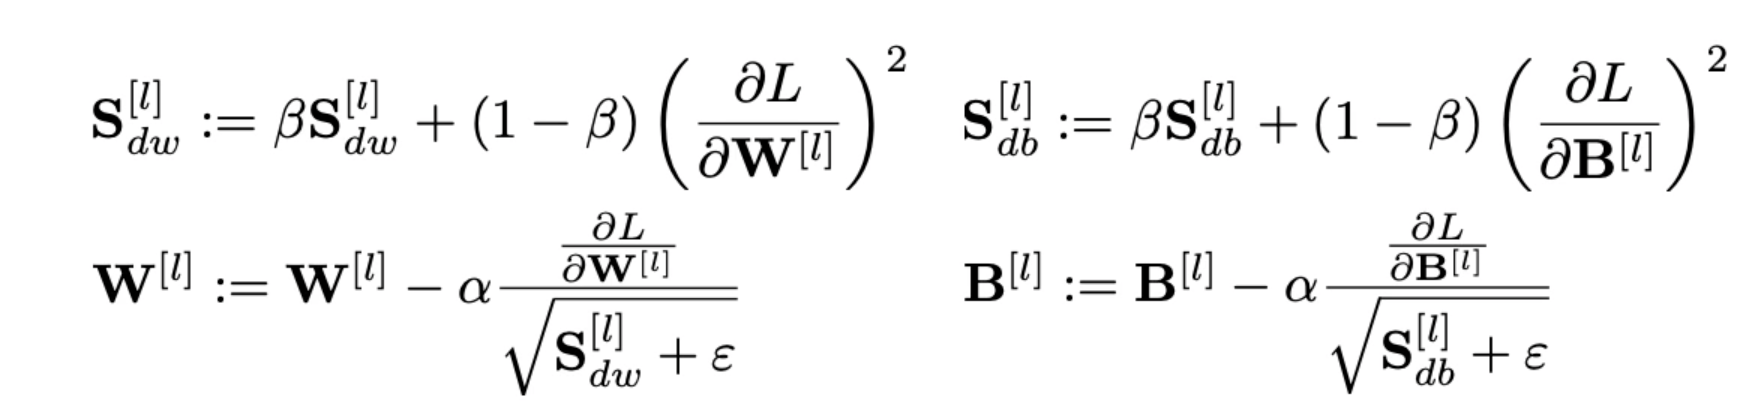
    - zero_gradメソッド
        - 勾配をリセットする

In [72]:
class RMSPropOptimizer():

    def __init__(self, parameters, lr=0.03, beta=0.9, eps=1e-8):
        self.parameters = list(parameters)
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.sqr_avg = [torch.zeros_like(param) for param in self.parameters] 

    def step(self):
        with torch.no_grad():
            for param, sqr_avg in zip(self.parameters, self.sqr_avg):
                sqr_avg[:] = self.beta * sqr_avg + (1-self.beta) * param.grad**2
                param -= self.lr * param.grad / (torch.sqrt(sqr_avg) + self.eps)
    
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [74]:
conv_model = utils.get_conv_model() 

# Optimizer
opt = RMSPropOptimizer(conv_model.parameters(), lr=0.03, beta=0.9)  # スクラッチ実装したRMSProp

# 学習
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.7696205801882986, validation error: 1.1362542629241943, validation accuracy: 0.5969168543815613


epoch: 1: train error: 0.4636462179280944, validation error: 0.5526927649974823, validation accuracy: 0.7918207883834839


epoch: 2: train error: 0.3991082740032067, validation error: 0.5127139031887055, validation accuracy: 0.8121910870075226


### PytorchのRMSProp

- torch.optim.RMSPropクラス
    - alpha: 減衰係数β
    - lr: 学習率
    - eps: 微小数値
    - 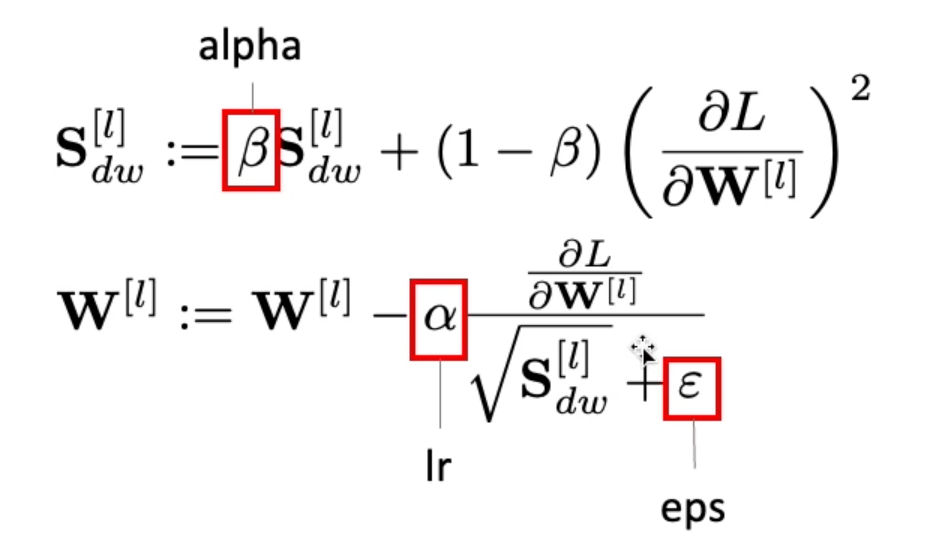

In [75]:
conv_model = utils.get_conv_model() 

# Optimizer
# opt = RMSPropOptimizer(conv_model.parameters(), lr=0.03, beta=0.9)  # スクラッチ実装したRMSProp
opt = RMSPropOptimizer(conv_model.parameters(), lr=0.03, beta=0.9, eps=1e-8)

# 学習
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.7346013829869739, validation error: 0.8920096278190612, validation accuracy: 0.7103256523609162


epoch: 1: train error: 0.4449659474825455, validation error: 0.6119903564453125, validation accuracy: 0.7867147624492645


epoch: 2: train error: 0.38484744550818106, validation error: 0.465293624997139, validation accuracy: 0.8288285255432128


### RMSPropにバイアス補正を追加

- 以前作成したRMSPropクラスにバイアス補正を追加する
- 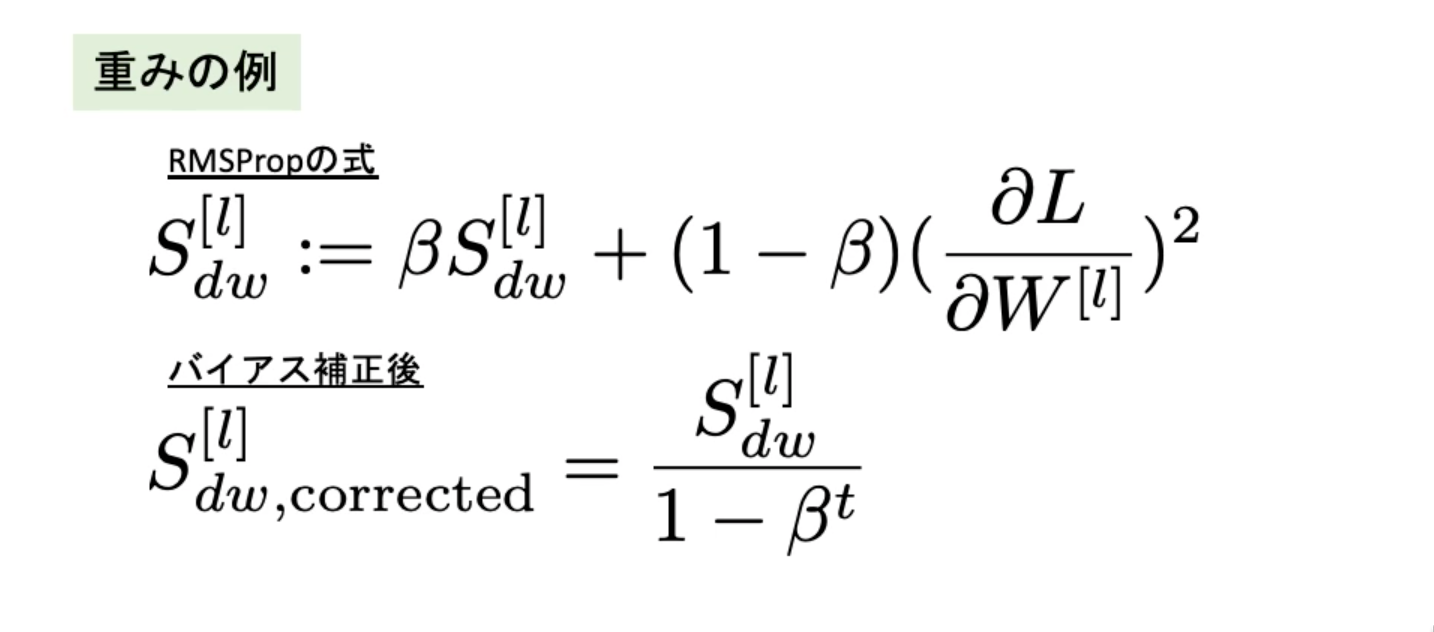

In [4]:
# バイアス補正追加バージョン
class RMSPropOptimizer():

    def __init__(self, parameters, lr=0.03, beta=0.9, eps=1e-8):
        self.parameters = list(parameters)
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.sqr_avg = [torch.zeros_like(param) for param in self.parameters] 
        self.t = 0  # カウント用

    def step(self):
        self.t += 1
        with torch.no_grad():
            for param, sqr_avg in zip(self.parameters, self.sqr_avg):
                sqr_avg[:] = self.beta * sqr_avg + (1-self.beta) * param.grad**2
                sqr_avg_corrected = sqr_avg / (1-self.beta**self.t)
                param -= self.lr * param.grad / (torch.sqrt(sqr_avg) + self.eps)
    
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [7]:
conv_model = utils.get_conv_model() 

# Optimizer
opt = RMSPropOptimizer(conv_model.parameters(), lr=0.03, beta=0.9, eps=1e-8)

# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,) )
])
train_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=4)

# 学習
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.7688973343978494, validation error: 0.5331391602754593, validation accuracy: 0.8034259378910065


epoch: 1: train error: 0.44301638764850165, validation error: 0.45561435222625735, validation accuracy: 0.8286790490150452


epoch: 2: train error: 0.38623232255547735, validation error: 0.4305282890796661, validation accuracy: 0.8487404346466064


## Adam

### Adamのスクラッチ実装

- 学習率、β1、β2、εを引数に取るOptimizerのクラスを実装する
- 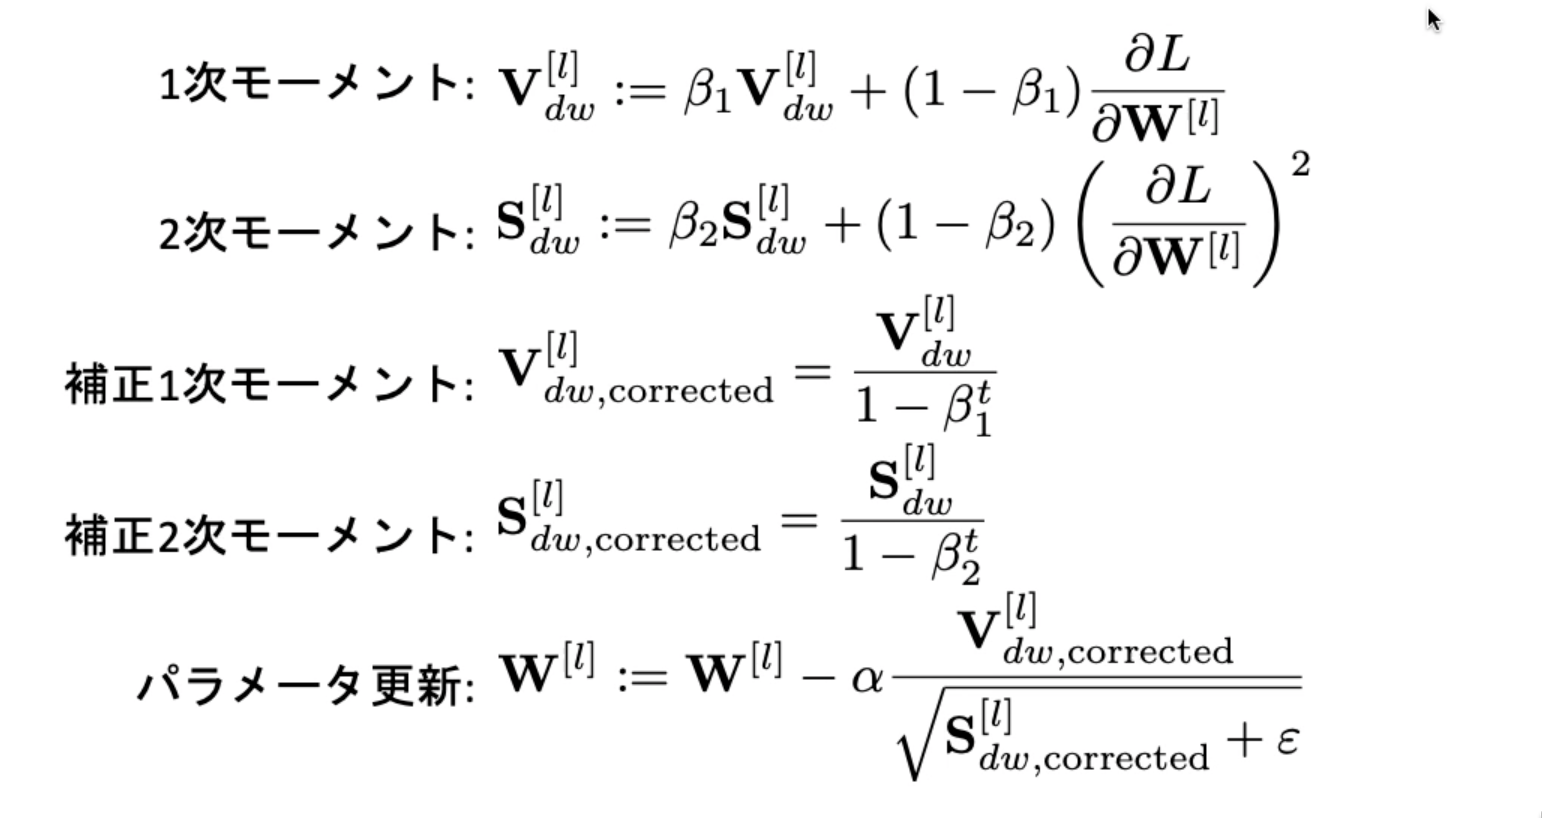

In [15]:
class AdamOptimizer():

    def __init__(self, parameters, lr=0.03, beta1=0.9, beta2=0.999, eps=1e-8):
        self.parameters = list(parameters)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.s = [torch.zeros_like(param) for param in self.parameters]
        self.t = 0 # カウント用

    def step(self):
        self.t += 1
        with torch.no_grad():
            for param, v, s in zip(self.parameters, self.v, self.s):
                # 1次モーメント
                v[:] = self.beta1 * v + (1-self.beta1) * param.grad
                v_corrected = v / (1-self.beta1**self.t)
                # 2次モーメント
                s[:] = self.beta2 * s + (1-self.beta2) * param.grad**2
                s_corrected = s / (1-self.beta2**self.t)
                # パラメータ更新
                param -= self.lr * v_corrected/(torch.sqrt(s_corrected)+self.eps)
    
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [16]:
conv_model = utils.get_conv_model() 

# Optimizer
opt = AdamOptimizer(conv_model.parameters(), lr=0.03, beta1=0.9, beta2=0.999, eps=1e-8)

# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,) )
])
train_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=4)

# 学習
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.6688666737685769, validation error: 0.45248339474201205, validation accuracy: 0.8330496668815612


epoch: 1: train error: 0.39869798290527475, validation error: 0.48835491836071016, validation accuracy: 0.8101124048233033


epoch: 2: train error: 0.3452067238799596, validation error: 0.400727191567421, validation accuracy: 0.8474410057067872


### PytorchでAdamを使用

- torch.optim.Adamクラス
    - params: モデルのパラメータ
    - lr: 学習率
    - betas: β1, β2（デフォルトは0.9, 0.999）
    - eps: ε（デフォルトでは1e-8）
- β1,β2,εはデフォルト値を使うことがほとんど

In [18]:
conv_model = utils.get_conv_model() 

# Optimizer
opt = optim.Adam(conv_model.parameters(), lr=0.03)

# 学習
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.6511381122015291, validation error: 0.4774890810251236, validation accuracy: 0.8220085322856903


epoch: 1: train error: 0.4007061098591756, validation error: 0.4282723397016525, validation accuracy: 0.8437978327274323


epoch: 2: train error: 0.35589203895148586, validation error: 0.4290425777435303, validation accuracy: 0.8401626288890839
